In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
from os.path import abspath, dirname, join, basename

plt.style.use('classic')

WDIR = "/home/lexi/eth-ramdisk/2018-08-05-vandal-output"

success_percentages = {}

In [2]:
# read combined output file from Vandal

errors = []
timeouts = []
contract_vulns = {}
vuln_contracts = {}
vandal_runtimes = {}
souffle_runtimes = {}

with open(join(WDIR, "combined.out")) as cf:
    for i, l in enumerate(cf):
        l = l.strip()
        cid = l.split(',')[0].split('_')[0]
        if 'ERROR' in l:
            errors.append(cid)
        elif 'TIMEOUT' in l:
            timeouts.append(cid)
        else:
            l = l.split(',')
            # (vandal runtime, souffle runtime)
            vandal_runtimes[cid] = float(l[1])
            souffle_runtimes[cid] = float(l[2])
            # build mapping contract_vulns: cid -> [vuln1, vuln2, ...]
            vuln_list = l[3:] if len(l[3]) > 0 else []
            contract_vulns[cid] = vuln_list
            # build mapping vuln_contracts: vuln -> [contract1, contract2, ...]
            for v in vuln_list:
                if v not in vuln_contracts:
                    vuln_contracts[v] = [cid]
                else:
                    vuln_contracts[v].append(cid)

total_contracts = len(errors) + len(timeouts) + len(contract_vulns)
print("Total:", total_contracts)

Total: 141099


In [3]:
# plot flagged vulns

vuln_counts = {vuln: len(vuln_contracts[vuln])/len(souffle_runtimes)*100 for vuln in vuln_contracts}
df = pd.DataFrame.from_dict(vuln_counts, orient='index')

column_names = {0: 'percentage of contracts flagged'}
row_names = {
    'uncheckedCall': 'Unchecked Send',
    'reentrantCall': 'Reentrancy',
    'unsecuredValueSend': 'Unsecured Balance',
    'accessibleSuicide': 'Destroyable',
    'originUsed': 'Use of ORIGIN',
}

#df = df.drop(['checkedCallThrows', 'checkedCallStateUpdate'])

<Figure size 432x288 with 0 Axes>

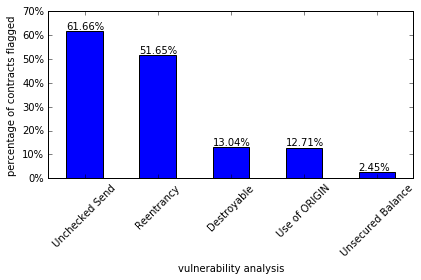

In [4]:
plt.figure()

df_vandal_detect = df.rename(row_names, columns=column_names)

ax = df.sort_values(0, ascending=False).rename(row_names, columns=column_names).plot.bar(legend=False)
ax.set_ylabel('percentage of contracts flagged')
ax.set_xlabel('vulnerability analysis')
#plt.show()

# add percent symbol on vertical axis
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2))+"%", (p.get_x(), p.get_height() + 1))

plt.ylim(ymax=70)

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('percentage_contracts_flagged.pdf')

In [5]:
# calculate runtime stats
times = vandal_runtimes.values()
stats = (min(times), sum(times)/len(times), max(times))
vandal_stats = (round(x,2) for x in stats)
print("Min/Avg/Max for Vandal:", *vandal_stats)

Min/Avg/Max for Vandal: 0.29 4.15 59.99


In [6]:
# timeout and error percentages

vandal_timeout_percent = len(timeouts)/total_contracts*100
vandal_error_percent = len(errors)/total_contracts*100
vandal_succ_percent = min(len(souffle_runtimes),len(vandal_runtimes))/total_contracts*100

print("% Timeout:", vandal_timeout_percent)
print("% Error:", vandal_error_percent)
print("% Success:", round(vandal_succ_percent, 2))

success_percentages['Vandal'] = {
    'Success': vandal_succ_percent,
    'Timeout': vandal_timeout_percent,
    'Error': vandal_error_percent,
}

% Timeout: 4.659848758672989
% Error: 0.06945477997717914
% Success: 95.27


In [7]:
# take into account vandal+souffle runtime:
real_timeouts = 0
for c, vr in vandal_runtimes.items():
    if vr + souffle_runtimes[c] > 60:
        real_timeouts += 1
print("Real timeouts:", real_timeouts+len(timeouts))
print("60vand+60souff timeouts:", len(timeouts))

Real timeouts: 9410
60vand+60souff timeouts: 6575


## Oyente Analysis

In [8]:
WDIR = "/home/lexi/eth-ramdisk/2018-08-06-oyente-output"

In [9]:
# read combined output file from Vandal

errors = []
timeouts = []
runtimes = {}

with open(join(WDIR, "combined.out")) as cf:
    for i, l in enumerate(cf):
        l = l.strip()
        cid = l.split(',')[0].split('_')[0]
        if 'ERROR' in l:
            errors.append(cid)
        elif 'TIMEOUT' in l:
            timeouts.append(cid)
        else:
            l = l.split(',')
            # (vandal runtime, souffle runtime)
            runtimes[cid] = float(l[1])

total_contracts = len(errors) + len(timeouts) + len(runtimes)
print("Total:", total_contracts)

Total: 141099


In [10]:
# calculate runtime stats
times = runtimes.values()
stats = (min(times), sum(times)/len(times), max(times))
oyente_stats = (round(x,2) for x in stats)
print("Min/Avg/Max for Oyente:", *oyente_stats)

Min/Avg/Max for Oyente: 0.26 13.68 60.01


In [11]:
# timeout and error percentages

oyente_timeout_percent = len(timeouts)/total_contracts*100
oyente_error_percent = len(errors)/total_contracts*100
oyente_succ_percent = len(runtimes)/total_contracts*100

print("% Timeout:", oyente_timeout_percent)
print("% Error:", oyente_error_percent)
print("% Success:", round(oyente_succ_percent, 2))

success_percentages['Oyente'] = {
    'Success': oyente_succ_percent,
    'Timeout': oyente_timeout_percent,
    'Error': oyente_error_percent,
}

% Timeout: 2.5485651918156753
% Error: 11.562094699466332
% Success: 85.89


In [12]:
# Analyse flagged vulnerabilities

# this file built with:
# % grep -r True . > ../flagged-true.txt

FLAGGED_TRUE = "flagged-true.txt"

# dict mapping contract addrs to sets of flagged vuln names
# e.g. {cid1 => {v1, v2, ...}, cid2 => {v1, ...}}
oyente_vulns = {}

# mapping vuln names to sets of contracts
oyente_vulns_contract = {}

with open(join(WDIR, FLAGGED_TRUE)) as flagged:
    for l in flagged:
        l = l.strip()
        # contract address
        cid = l.split('_')[1]
        # name of the vuln
        vuln = l.split(':')[3].strip()
        if cid in oyente_vulns:
            oyente_vulns[cid].add(vuln)
        else:
            oyente_vulns[cid] = {vuln}
        if vuln in oyente_vulns_contract:
            oyente_vulns_contract[vuln].add(cid)
        else:
            oyente_vulns_contract[vuln] = {cid}

In [13]:
vuln_counts = {vuln: len(oyente_vulns_contract[vuln])/len(runtimes)*100 for vuln in oyente_vulns_contract}
df = pd.DataFrame.from_dict(vuln_counts, orient='index')

column_names = {0: 'percentage of contracts flagged'}
row_names = {
    'Transaction-Ordering Dependence (TOD)': 'TX Order Dep.',
    'Timestamp Dependency': 'Timestamp Dep.',
    'Re-Entrancy Vulnerability': 'Reentrancy',
    'Callstack Depth Attack Vulnerability': 'Callstack',
}

df

0
Transaction-Ordering Dependence (TOD)  9.580077
Timestamp Dependency                   2.992846
Re-Entrancy Vulnerability              1.317776
Callstack Depth Attack Vulnerability   1.944896

<Figure size 432x288 with 0 Axes>

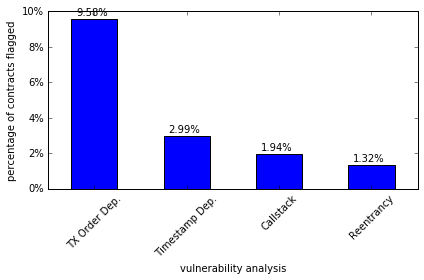

In [14]:
plt.figure()

ax = df.sort_values(0, ascending=False).rename(row_names, columns=column_names).plot.bar(legend=False)
ax.set_ylabel('percentage of contracts flagged')
ax.set_xlabel('vulnerability analysis')
#plt.show()

# add percent symbol on vertical axis
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2))+"%", (p.get_x()+0.05, p.get_height() + 0.2))

plt.ylim(ymax=10)

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('oyente_percentage_contracts_flagged.pdf')

## EthIR Analysis

In [15]:
WDIR = "/home/lexi/eth-ramdisk/2018-08-05-EthIR-output"

In [16]:
# read combined output file from Vandal

errors = []
timeouts = []
runtimes = {}

with open(join(WDIR, "combined.out")) as cf:
    for i, l in enumerate(cf):
        l = l.strip()
        cid = l.split(',')[0].split('_')[0]
        if 'ERROR' in l:
            errors.append(cid)
        elif 'TIMEOUT' in l:
            timeouts.append(cid)
        else:
            l = l.split(',')
            # (vandal runtime, souffle runtime)
            runtimes[cid] = float(l[1])

total_contracts = len(errors) + len(timeouts) + len(runtimes)
print("Total:", total_contracts)

Total: 141099


In [17]:
# calculate runtime stats
times = runtimes.values()
stats = (min(times), sum(times)/len(times), max(times))
ethir_stats = (round(x,2) for x in stats)
print("Min/Avg/Max for EthIR:", *ethir_stats)

Min/Avg/Max for EthIR: 0.25 11.99 59.99


In [18]:
# timeout and error percentages

ethir_timeout_percent = len(timeouts)/total_contracts*100
ethir_error_percent = len(errors)/total_contracts*100
ethir_succ_percent = len(runtimes)/total_contracts*100

print("% Timeout:", round(ethir_timeout_percent, 2))
print("% Error:", round(ethir_error_percent, 2))
print("% Success:", round(ethir_succ_percent, 2))

success_percentages['EthIR'] = {
    'Success': ethir_succ_percent,
    'Timeout': ethir_timeout_percent,
    'Error': ethir_error_percent,
}

% Timeout: 0.37
% Error: 19.94
% Success: 79.69


## Mythril Analysis

In [19]:
WDIR = "/home/lexi/eth-ramdisk/2018-09-07-mythril-output"

In [20]:
# read combined output file from Vandal

errors = []
timeouts = []
runtimes = {}

with open(join(WDIR, "combined.out")) as cf:
    for i, l in enumerate(cf):
        l = l.strip()
        cid = l.split(',')[0].split('_')[0]
        if 'ERROR' in l:
            errors.append(cid)
        elif 'TIMEOUT' in l:
            timeouts.append(cid)
        else:
            l = l.split(',')
            # (vandal runtime, souffle runtime)
            runtimes[cid] = float(l[1])

total_contracts = len(errors) + len(timeouts) + len(runtimes)
print("Total:", total_contracts)

Total: 141099


In [21]:
# calculate runtime stats
times = runtimes.values()
stats = (min(times), sum(times)/len(times), max(times))
mythril_stats = (round(x,2) for x in stats)
print("Min/Avg/Max for Mythril:", *mythril_stats)

Min/Avg/Max for Mythril: 1.47 11.1 59.99


In [22]:
# timeout and error percentages

mythril_timeout_percent = len(timeouts)/total_contracts*100
mythril_error_percent = len(errors)/total_contracts*100
mythril_succ_percent = len(runtimes)/total_contracts*100

print("% Timeout:", mythril_timeout_percent)
print("% Error:", mythril_error_percent)
print("% Success:", round(mythril_succ_percent, 2))

success_percentages['Mythril'] = {
    'Success': mythril_succ_percent,
    'Timeout': mythril_timeout_percent,
    'Error': mythril_error_percent,
}

% Timeout: 26.57566673045167
% Error: 53.43340491428005
% Success: 19.99


In [23]:
# Analyse flagged vulnerabilities

# vulns file generated with:
# % grep -r '====' ./mythril-output > detected-vulns.txt
VULNS_FILE = "detected-vulns.txt"

# dict mapping contract addrs to sets of flagged vuln names
# e.g. {cid1 => {v1, v2, ...}, cid2 => {v1, ...}}
mythril_vulns = {}

# mapping vuln names to sets of contracts
mythril_vulns_contract = {}

with open(join(WDIR, VULNS_FILE)) as flagged:
    for l in flagged:
        l = l.strip()
        # contract address
        cid = l.split('_')[1]
        # name of the vuln
        vuln = l.split(':')[1].strip('= ').strip()
        if cid in mythril_vulns:
            mythril_vulns[cid].add(vuln)
        else:
            mythril_vulns[cid] = {vuln}
        if vuln in mythril_vulns_contract:
            mythril_vulns_contract[vuln].add(cid)
        else:
            mythril_vulns_contract[vuln] = {cid}
            
#list(mythril_vulns_contract.keys())

In [24]:
vuln_counts = {vuln: len(mythril_vulns_contract[vuln])/len(runtimes)*100 for vuln in mythril_vulns_contract}
df = pd.DataFrame.from_dict(vuln_counts, orient='index')

column_names = {0: 'percentage of contracts flagged'}
row_names = {
    #'Transaction order dependence': 'TX Order Dep.',
    'Unchecked CALL return value': 'Unchecked Send',
    'Unchecked SUICIDE': 'Destroyable',
    'Use of tx.origin': 'Use of ORIGIN',
    'Ether send': 'Unsecured Balance',
    'Message call to external contract': 'Reentrancy',
}


to_drop = [i for i in df.index if i not in row_names]
df = df.drop(to_drop)
df

0
Message call to external contract  52.618144
Unchecked CALL return value        12.844329
Ether send                          1.999504
Use of tx.origin                    1.201829
Unchecked SUICIDE                   1.439359

<Figure size 432x288 with 0 Axes>

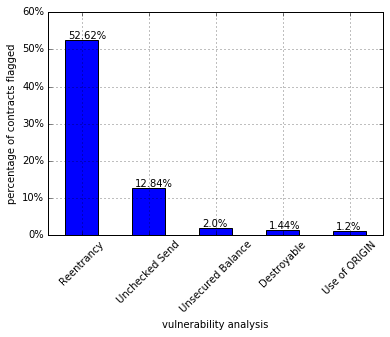

In [25]:
plt.figure()

df_myth_detect = df.rename(row_names, columns=column_names)

ax = df.sort_values(0, ascending=False).rename(row_names, columns=column_names).plot.bar(legend=False, grid=True)
ax.set_ylabel('percentage of contracts flagged')
ax.set_xlabel('vulnerability analysis')
#plt.show()

# add percent symbol on vertical axis
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2))+"%", (p.get_x()+0.05, p.get_height() + 0.2))

#plt.ylim(ymax=15)

plt.xticks(rotation=45)

#plt.tight_layout()
plt.savefig('mythril_percentage_contracts_flagged.pdf')

## Rattle Analysis

In [26]:
WDIR = "/home/lexi/eth-ramdisk/2018-09-08-rattle-output"

In [27]:
# read combined output file from Vandal

errors = []
timeouts = []
runtimes = {}

with open(join(WDIR, "combined.out")) as cf:
    for i, l in enumerate(cf):
        l = l.strip()
        cid = l.split(',')[0].split('_')[0]
        if 'ERROR' in l:
            errors.append(cid)
        elif 'TIMEOUT' in l:
            timeouts.append(cid)
        else:
            l = l.split(',')
            # (vandal runtime, souffle runtime)
            runtimes[cid] = float(l[1])

total_contracts = len(errors) + len(timeouts) + len(runtimes)
print("Total:", total_contracts)

Total: 141099


In [28]:
# calculate runtime stats
times = runtimes.values()
stats = (min(times), sum(times)/len(times), max(times))
rattle_stats = (round(x,2) for x in stats)
print("Min/Avg/Max for Rattle:", *rattle_stats)

Min/Avg/Max for Rattle: 0.12 4.47 60.0


In [29]:
# timeout and error percentages

rattle_timeout_percent = len(timeouts)/total_contracts*100
rattle_error_percent = len(errors)/total_contracts*100
rattle_succ_percent = len(runtimes)/total_contracts*100

print("% Timeout:", round(rattle_timeout_percent, 2))
print("% Error:", round(rattle_error_percent, 2))
print("% Success:", round(rattle_succ_percent, 2))

success_percentages['Rattle'] = {
    'Success': rattle_succ_percent,
    'Timeout': rattle_timeout_percent,
    'Error': rattle_error_percent,
}

% Timeout: 0.66
% Error: 27.54
% Success: 71.81


## Cross-Tool Comparison

In [30]:
df2 = pd.DataFrame.from_dict(success_percentages, orient="index")
df2

Success    Timeout      Error
EthIR    79.686603   0.369244  19.944153
Mythril  19.990928  26.575667  53.433405
Oyente   85.889340   2.548565  11.562095
Rattle   71.805612   0.656986  27.537403
Vandal   95.270696   4.659849   0.069455

<Figure size 432x288 with 0 Axes>

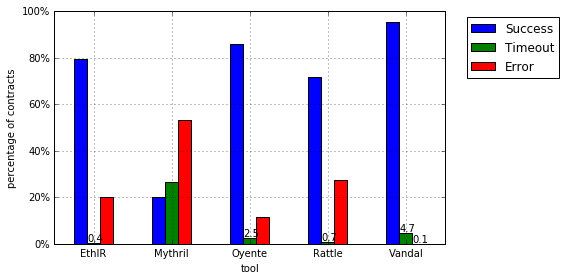

In [31]:
plt.figure()
ax = df2.plot.bar(legend=True, figsize=(8,4), stacked=False, grid=True)

ax.set_ylabel("percentage of contracts")
ax.set_xlabel("tool")

# add percent symbol on vertical axis
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
ax.yaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)

for p in ax.patches:
    if p.get_height() < 5:
        ax.annotate(str(float(round(p.get_height(), 1)))+"", (p.get_x()+0.0, p.get_height() +0.8))#, rotation=90, color='white')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('tool_succ_comparison.pdf')

In [33]:
df3 = pd.concat((df_vandal_detect.transpose().rename({'percentage of contracts flagged': 'Vandal'}),
                 df_myth_detect.transpose().rename({'percentage of contracts flagged': 'Mythril'}),), sort=True)
df3

Destroyable  Reentrancy  Unchecked Send  Unsecured Balance  \
Vandal     13.042864   51.649978       61.655483           2.454138   
Mythril     1.439359   52.618144       12.844329           1.999504   

         Use of ORIGIN  
Vandal       12.712570  
Mythril       1.201829

<Figure size 432x288 with 0 Axes>

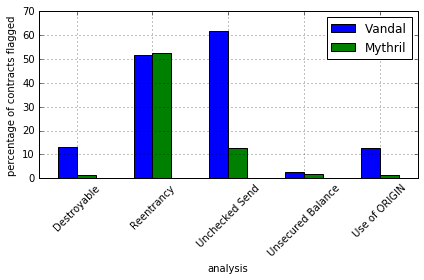

In [46]:
plt.figure()

ax = df3.transpose().plot.bar(grid=True, figsize=(6,4))

ax.set_ylabel("percentage of contracts flagged")
ax.set_xlabel("analysis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('flag_comparison.pdf')